# Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle

In [22]:
PATH = 'data/shakespeare/'

TRN = f'{PATH}trn.txt'
VAL = f'{PATH}val.txt'

!ls {PATH}

models	shakespeare_input.txt  trn.txt	val.txt


In [16]:
# example of text
!cat {TRN} | tail -10

Has forgot Britain.

IACHIMO:
And himself. Not I,
Inclined to this intelligence, pronounce
The beggary of his change; but 'tis your graces
That from pay mutest conscience to my tongue
Charms this report out.

IMOGEN:


# LanguageModelData by word

#### Tokenize text

In [20]:
# torchtext field object - describes how to process input
TEXT = data.Field(lower=True, tokenize=spacy_tok)

bs = 64
bptt = 70

FILES = dict(train='trn.txt', validation='val.txt', test='val.txt')
# fastai model data object
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

In [87]:
# save TEXT (now with vocab attribute) -> #.itos, #.stoi
os.makedirs(f'{PATH}models/word', exist_ok=True)
pickle.dump(TEXT, open(f'{PATH}models/word/TEXT.pkl','wb'))

In [23]:
# batches, unique tokens, tokens in dataset 
len(md.trn_dl), md.nt, len(md.trn_ds[0].text)

(209, 4959, 1, 941879)

#### Explore data loader batches

In [57]:
# BATCH --  data: ~bptt x bs;   label: 1d array of next word
batch = next(iter(md.trn_dl)); batch

(Variable containing:
   107    11    28  ...     49     4    19
   517  3367   217  ...    664    58   317
     3    35    72  ...    458     2     2
        ...          ⋱          ...       
     2    28     0  ...      7    16   159
     6   570     2  ...     22   101   237
    44     2  2059  ...      5     2     2
 [torch.cuda.LongTensor of size 73x64 (GPU 0)], Variable containing:
   517
  3367
   217
   ⋮  
  4077
  4303
  1116
 [torch.cuda.LongTensor of size 4672 (GPU 0)])

In [ ]:
ds = batch[0].data   # .data - retrieve tensor from variable

In [58]:
label = batch[1].data

In [55]:
reverser = lambda o: TEXT.vocab.itos[o]
itos_func = np.vectorize(reverser)

In [56]:
itos_func(ds)

array([['first', 'you', 'his', ..., 'are', '.', '!'],
       ['citizen', 'chose', 'friends', ..., 'past', 'come', 'earth'],
       [':', 'him', 'there', ..., 'service', ',', ','],
       ...,
       [':', 'you', 'name', ..., 'yourself', 'the', 'gold'],
       ['resolved', 'against', 'is', ..., 'wrong', 'world', '?'],
       ['.', 'the', 'not', ..., ':', '?', 'no']], dtype='<U12')

In [59]:
itos_func(label)

array(['citizen', 'chose', 'friends', ..., 'limb', 'magic', 'coward'], dtype='<U14')

#### Train

In [60]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [61]:
opt_fn = partial(optim.Adam, betas=(.7, .99))

In [72]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.1, dropout=0.1, wdrop=0.2, dropoute=0.04, dropouth=0.1)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [73]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 90%|█████████ | 189/209 [00:25<00:02,  7.39it/s, loss=24.8]

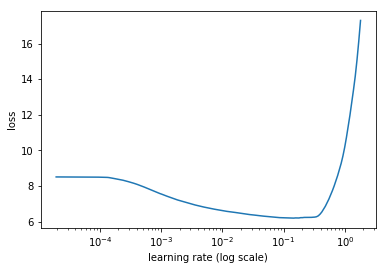

In [74]:
learner.sched.plot()

In [76]:
learner.fit(1e-2, 5, wds=1e-6, cycle_len=5)

HBox(children=(IntProgress(value=0, description='Epoch', max=25), HTML(value='')))

 21%|██        | 44/209 [00:05<00:21,  7.79it/s, loss=8.06]

Exception in thread Thread-33:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                              
    0      5.783375   5.401047  
    1      5.021159   4.850568                              
    2      4.760013   4.679566                              
    3      4.647942   4.606828                              
    4      4.592665   4.578878                              
    5      4.623974   4.571738                              
    6      4.511236   4.490897                              
    7      4.408905   4.428314                              
    8      4.332114   4.375502                              
    9      4.299499   4.372693                              
    10     4.39012    4.40294                               
    11     4.311449   4.349155                              
    12     4.219852   4.305293                              
    13     4.140891   4.275035                              
    14     4.117384   4.275783                              
    15     4.250031   4.318419                      

[4.222391]

In [82]:
learner.fit(1e-2, 2, wds=1e-6, cycle_len=10)

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      4.056804   4.282621  
    1      4.070535   4.262603                              
    2      4.041001   4.252559                              
    3      3.999774   4.242208                              
    4      3.959328   4.239118                              
    5      3.913321   4.219591                              
    6      3.865484   4.213597                              
    7      3.826077   4.208253                              
    8      3.802114   4.203265                              
    9      3.79449    4.207988                              
    10     4.012111   4.266161                              
    11     4.00311    4.252134                              
    12     3.98058    4.240265                              
    13     3.939534   4.222657                              
    14     3.906677   4.212936                              
    15     3.837436   4.213698                      

[4.2085037]

In [83]:
learner.save('45_cycles_4.20')

In [ ]:
learner.fit(1e-2, 5, wds=1e-6, cycle_len=5)

In [77]:
learner.save('25_cycles_4.22')

#### Generate some test text

In [79]:
m=learner.model
primer=""" """
s = [spacy_tok(primer)]
t=TEXT.numericalize(s)
' '.join(s[0])

' '

In [84]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

In [86]:
# generate 50 words
for i in range(200):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

: i know him well . what , ho ! what news ? messenger : my lord , i know not what . hamlet : i 'll tell you , sir , that you are not a man . ophelia : i am sorry that my lord is dead . hamlet : i am a fool , and i am sure you are not . ophelia : i am a fool , my lord . hamlet : i am a fool , and i am not a fool . ophelia : i am a fool , my lord . hamlet : i am a fool , sir , and i am a fool . ophelia : i am a fool , my lord . hamlet : i am a fool , sir . ophelia : i am a fool , my lord . hamlet : i am a fool , sir . ophelia : i am a fool , my lord . hamlet : i am a fool , sir . ophelia : i am a fool , my lord . hamlet : i am a fool , sir . ophelia : i am a fool , my lord . ...


# LanguageModelData by character

#### Tokenize text

In [91]:
# torchtext field object - describes how to process input
TEXT = data.Field(lower=True, tokenize=list)

bs = 64
bptt = 200

FILES = dict(train='trn.txt', validation='val.txt', test='val.txt')
# fastai model data object
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

In [92]:
# save TEXT (now with vocab attribute) -> #.itos, #.stoi
os.makedirs(f'{PATH}models/char', exist_ok=True)
pickle.dump(TEXT, open(f'{PATH}models/char/TEXT.pkl','wb'))

In [93]:
# batches, unique chars, chars in dataset 
len(md.trn_dl), md.nt, len(md.trn_ds[0].text)

(307, 39, 3949470)

#### Train

In [94]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [95]:
opt_fn = partial(optim.Adam, betas=(.7, .99))

In [96]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.1, dropout=0.1, wdrop=0.2, dropoute=0.04, dropouth=0.1)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [97]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▏ | 252/307 [01:19<00:17,  3.18it/s, loss=10.3]

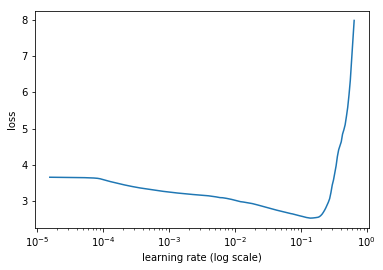

In [98]:
learner.sched.plot()

In [99]:
learner.fit(1e-3, 5, wds=1e-6)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  6%|▌         | 17/307 [00:05<01:32,  3.13it/s, loss=3.25]

Exception in thread Thread-79:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                              
    0      2.149064   1.973366  
    1      1.756375   1.648479                              
    2      1.585248   1.527809                              
    3      1.535328   1.484868                              
    4      1.485981   1.446952                              



[1.4469517]

In [100]:
learner.save('5_cycles_1.44')

In [101]:
learner.fit(1e-3, 5, wds=1e-6, cycle_len=5)

HBox(children=(IntProgress(value=0, description='Epoch', max=25), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.456382   1.430118  
    1      1.449606   1.412575                              
    2      1.408196   1.398255                              
    3      1.402903   1.390815                              
    4      1.414043   1.389208                              
    5      1.424497   1.391573                              
    6      1.402332   1.379109                              
    7      1.37727    1.370483                              
    8      1.376962   1.364636                              
    9      1.374661   1.363242                              
    10     1.377366   1.367704                              
    11     1.373221   1.360365                              
    12     1.367682   1.350899                              
    13     1.352277   1.345672                              
    14     1.343966   1.344525                              
    15     1.369435   1.352744                      

[1.3224372]

In [102]:
learner.save('30_cycles_1.32')

#### Test

In [ ]:
learner.fit(1e-3, 5, wds=1e-6)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  6%|▌         | 17/307 [00:05<01:32,  3.13it/s, loss=3.25]

Exception in thread Thread-79:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 22%|██▏       | 68/307 [00:21<01:15,  3.15it/s, loss=3.04]